In [139]:
import pandas as pd
from sklearn.linear_model import LinearRegression

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import seaborn as sn

In [140]:
pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [141]:
childhood_obesity = pd.read_csv('coursework_1_data_2019.csv')

In [142]:
obesity_ratio = []

In [143]:
childhood_obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   obesity_diff         152 non-null    float64
 1   clean_air_ra         152 non-null    float64
 2   clean_environ_ra     152 non-null    float64
 3   health_training_ra   152 non-null    float64
 4   school_awareness_ra  152 non-null    float64
 5   media_awareness_ra   152 non-null    float64
 6   sub_counselling_ra   152 non-null    float64
dtypes: float64(7)
memory usage: 8.4 KB


In [144]:
childhood_obesity.head()

,obesity_diff,clean_air_ra,clean_environ_ra,health_training_ra,school_awareness_ra,media_awareness_ra,sub_counselling_ra
0,0.0006,0.1511,0.1583,0.1295,0.2950,0.1295,0.1367
1,0.0006,0.2273,0.0773,0.1045,0.3364,0.1364,0.1182
2,0.0006,0.2562,0.2812,0.0312,0.1625,0.1812,0.0875
3,0.0002,0.2050,0.2609,0.1180,0.3106,0.0621,0.0435
4,0.0003,0.2846,0.4000,0.1308,0.0615,0.0231,0.1000


In [145]:
# clean data
# z-score
def outlier_test(data, column, method=None, z=2.5):
    # IQR
    if method == None:
        print(f'Use IQR to check for outliers based on the {column}')
        print('=' * 70)
    
        column_iqr = np.quantie(data[column], 0.75) - np.quantile(data[column], 0.25)
        (q1, q3) = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)
        upper, lower = (q3 + 1.5 * column_iqr), (q1 - 1.5 * column_iqr)
        outlier = data[(data[column] <= lower) | (data[column] >= upper)]
        return outlier, upper, lower

    # z-score
    if method == 'z':
        print(f'Use z-score to check for outliers based on the {column}, z-score takes {z} to detect outliers')
        print('=' * 70)
        mean, std=np.mean(data[column]), np.std(data[column])
        upper, lower = (mean + z*std), (mean - z*std)
        outlier = data[(data[column] <= lower) | (data[column] >= upper)]
        return outlier, upper, lower

In [146]:
outlier, upper, lower= outlier_test(data = childhood_obesity, column = 'obesity_diff', method = 'z')
outlier.info(); outlier.sample()

Use z-score to check for outliers based on the obesity_diff, z-score takes 2.5 to detect outliers
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 7 to 7
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   obesity_diff         1 non-null      float64
 1   clean_air_ra         1 non-null      float64
 2   clean_environ_ra     1 non-null      float64
 3   health_training_ra   1 non-null      float64
 4   school_awareness_ra  1 non-null      float64
 5   media_awareness_ra   1 non-null      float64
 6   sub_counselling_ra   1 non-null      float64
dtypes: float64(7)
memory usage: 64.0 bytes


,obesity_diff,clean_air_ra,clean_environ_ra,health_training_ra,school_awareness_ra,media_awareness_ra,sub_counselling_ra
7,0.0012,0.1648,0.1758,0.1429,0.2308,0.1978,0.0879


In [147]:
childhood_obesity.drop(index = outlier.index, inplace = True)

Text(0.5, 1.0, 'Correlation Matrix')

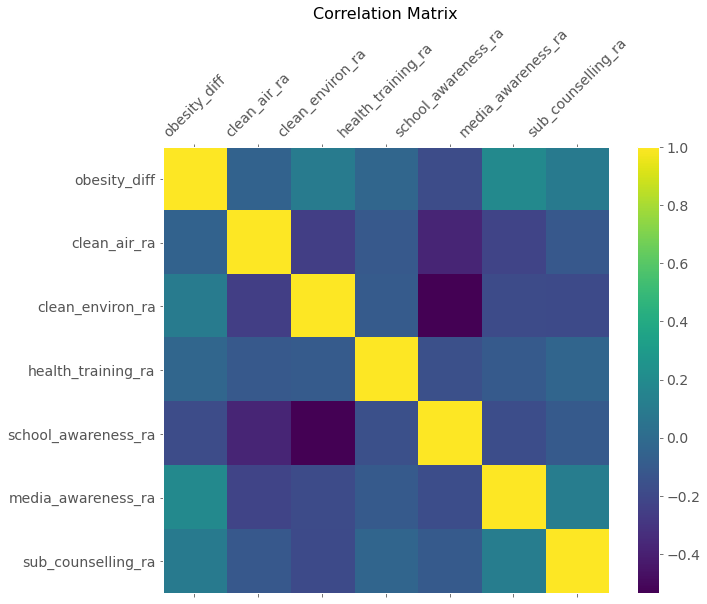

In [162]:
df = childhood_obesity
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(10, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [149]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [150]:
childhood_obesity_new = drop_column_using_vif_(childhood_obesity.drop('obesity_diff', axis=1))

Dropping: clean_environ_ra


/opt/conda/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [152]:
childhood_obesity.columns

Index(['obesity_diff', 'clean_air_ra', 'clean_environ_ra',
       'health_training_ra', 'school_awareness_ra', 'media_awareness_ra',
       'sub_counselling_ra'],
      dtype='object')

In [153]:
# using VIF on the dataset

df_predictors_selected_VIF = drop_column_using_vif_(childhood_obesity.drop('obesity_diff', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: clean_environ_ra
The columns remaining after VIF selection are:
Index(['clean_air_ra', 'health_training_ra', 'school_awareness_ra',
       'media_awareness_ra', 'sub_counselling_ra'],
      dtype='object')


/opt/conda/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [155]:
model_childhood_obesity = sm.OLS(endog=childhood_obesity[['obesity_diff']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_childhood_obesity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           obesity_diff   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     2.136
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0644
Time:                        23:47:57   Log-Likelihood:                 1050.1
No. Observations:                 151   AIC:                            -2088.
Df Residuals:                     145   BIC:                            -2070.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0005      0.000      3.297      0.001       0.000       0.001
clean_air_ra           -0.0003      0.000     -1.060      0.291      -0.001       0.000
health_training_ra     -0.0003      0.000     -0.649      0.517      -0.001       0.001
school_awareness_ra    -0.0005      0.000     -2.096      0.038      -0.001   -2.66e-05
media_awareness_ra      0.0005      0.000      1.368      0.173      -0.000       0.001
sub_counselling_ra      0.0003      0.001      0.559      0.577      -0.001       0.002
==============================================================================
Omnibus:                        4.481   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                2.668
Skew:                           0.089   Prob(JB):                        0.263
Kurtosis:                       2.374   Cond. No.                         33.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

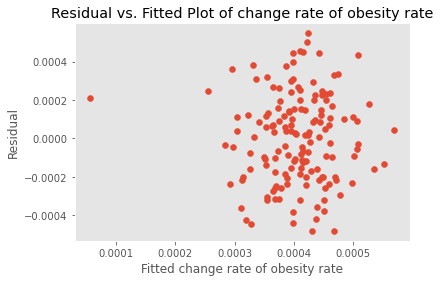

In [163]:
# plot 
plt.scatter(model_childhood_obesity.fittedvalues, model_childhood_obesity.resid)
# adding title and labels
plt.xlabel('Fitted change rate of obesity rate')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of change rate of obesity rate')
plt.show()

eval_env: 1


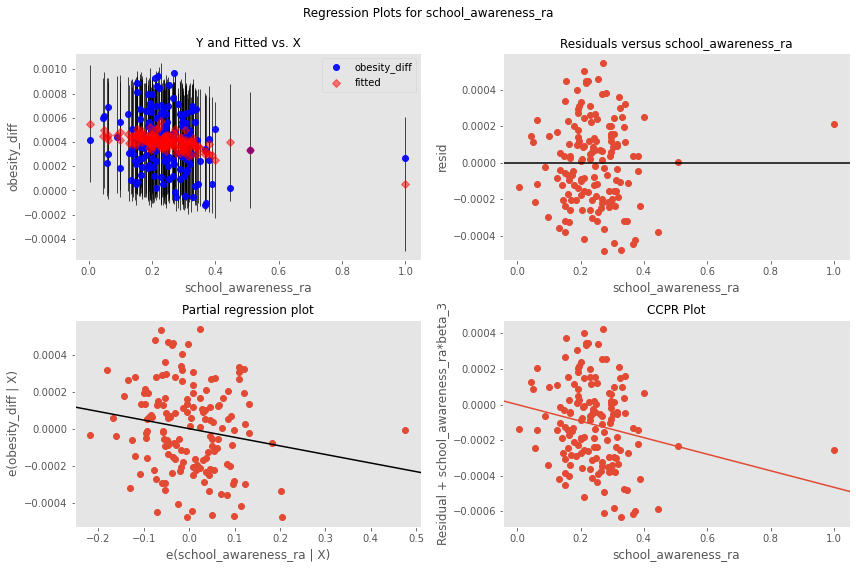

In [156]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_childhood_obesity, 'school_awareness_ra', fig=fig)